# Run Any Kind of Logistic Regression (Binomial, Multinomial, etc.)

### Authors: Calvin Howard.

#### Last updated: March 16, 2024

Use this to run/test a statistical model on a spreadsheet.

Notes:
- To best use this notebook, you should be familar with GLM design and Contrast Matrix design. See this webpage to get started:
[FSL's GLM page](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM)

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

Prep Output Directory

In [4]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/dataset_4/Figs/no_peak_atrophy'

Import Data

In [5]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/dataset_4/updated_differential_diagnosis_matrix_peak.csv'
sheet = None

In [6]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df

,DX,SUBID,AD,SV,LBD,BV,PNFA,CBS,PSP,CN,Peak_Values
0,AD,002_S_5018,0.274697,0.236974,0.206284,0.058076,-0.003556,-0.061958,0.064401,0.049505,3.958120
1,AD,003_S_4136,0.266863,0.169714,0.301794,0.238919,-0.043050,-0.090273,0.064663,0.087982,6.707466
2,AD,003_S_4152,0.309767,-0.005867,0.270765,0.351072,0.321640,0.089697,0.102666,0.050549,4.700880
3,AD,003_S_4373,0.294166,0.104773,-0.059247,-0.024040,0.153165,0.140114,-0.098544,0.048240,5.562066
4,AD,003_S_4892,0.121190,0.085156,0.030894,-0.043562,-0.043216,-0.089155,-0.109166,0.000851,3.858787
...,...,...,...,...,...,...,...,...,...,...,...
622,PSP,1_S_5091,-0.012585,-0.076982,0.241457,0.274615,0.300414,0.273924,0.359884,0.110915,3.304003
623,PSP,1_S_5093,0.112110,-0.065346,0.100739,0.054500,0.171525,0.404358,0.306781,0.009772,4.854170
624,PSP,1_S_5095,0.071034,0.060069,0.256409,0.249248,0.212178,0.206000,0.235424,0.072760,3.043384
625,PSP,1_S_5096,0.108565,0.106482,0.135455,0.173665,0.149068,0.216797,0.304357,0.069126,5.483599


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [123]:
drop_list = ['DIAGNOSIS_BL_Str', 'CSF_Cerebellum']


In [124]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

,subid,Age,Male,Female,CSF_Cerebellum,CSF_Subcortex,CSF_MTL,CSF_Occipital,CSF_Frontal,CSF_Parietal,...,TOTAL11,TOTALMOD,DX_BASELINE,DX_M12,DIAGNOSIS_BL,DIAGNOSIS_CURRENT,DIAGNOSIS_M12,DIAGNOSIS_BL_Str,DIAGNOSIS_CURRENT_Str,DIAGNOSIS_M12_Str
0,002_S_0295,84.898630,1.0,0.0,-26319.381520,373.297842,-746.688684,-24081.964640,-32607.592110,-18245.868460,...,3.00,4.00,Normal,Normal,1.0,1.0,1.0,Normal,Normal,Normal
1,002_S_0413,76.397260,0.0,1.0,-13670.888710,5009.504947,-449.838607,-8185.340726,-13903.977170,-6191.852471,...,3.33,4.33,Normal,Normal,1.0,1.0,1.0,Normal,Normal,Normal
2,002_S_0954,69.452055,0.0,1.0,-27912.718120,267.960111,-26.245064,-14384.382220,1174.325661,-13108.994170,...,10.67,21.67,MCI,Alzheimer,2.0,3.0,3.0,MCI,Alzheimer,Alzheimer
3,003_S_1057,61.273973,0.0,1.0,-3441.984646,8102.022733,-157.009052,-11631.937370,-11106.858210,-14756.563150,...,11.33,20.33,MCI,MCI,2.0,3.0,2.0,MCI,Alzheimer,MCI
4,003_S_1122,76.764384,0.0,1.0,-9127.083112,8399.639128,-57.383241,-11919.752740,1985.249349,-7048.794398,...,5.00,9.00,MCI,MCI,2.0,2.0,2.0,MCI,MCI,MCI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,941_S_4365,80.410959,1.0,0.0,-38529.962160,-15404.929680,-662.636580,-45763.001790,-51966.135180,-50434.470830,...,NaN,NaN,NaN,NaN,1.0,3.0,1.0,Normal,Alzheimer,Normal
1301,941_S_4376,76.594521,0.0,1.0,-17949.114530,-104.528538,-236.251734,-30861.230910,-12256.220060,-26738.830580,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,Normal,Normal,Normal
1302,941_S_4377,69.421918,0.0,1.0,-15992.361930,8601.241440,-63.774856,-17403.780770,-5480.603967,-8570.005333,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,MCI,MCI,MCI
1303,941_S_4420,81.493151,1.0,0.0,-16826.370250,-551.877244,-240.304833,-19856.342990,-43372.373360,-24995.432550,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,MCI,MCI,MCI


**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [7]:
data_df.columns

Index(['study_id', 'redcap_event_name', 'acute_beh', 'acute_scan',
       'missed_visit_a', 'visit_note_a', 'three_m_beh', 'three_m_scan',
       'missed_visit_3m', 'visit_note_3m',
       ...
       'sis_8_a', 'sis_8_b', 'sis_8_c', 'sis_8_d', 'sis_8_e', 'sis_8_f',
       'sis_8_g', 'sis_8_h', 'sis_total',
       'functional_outcome_battery_complete'],
      dtype='object', length=495)

Set the parameters for dropping rows

In [10]:
column = 'redcap_event_name'  # The column you'd like to evaluate
condition = 'equal'  # The condition to check ('equal', 'above', 'below', 'not')
value = '3month_arm_1' # The value to drop if found

In [11]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
display(data_df)

,study_id,redcap_event_name,acute_beh,acute_scan,missed_visit_a,visit_note_a,three_m_beh,three_m_scan,missed_visit_3m,visit_note_3m,...,sis_8_a,sis_8_b,sis_8_c,sis_8_d,sis_8_e,sis_8_f,sis_8_g,sis_8_h,sis_total,functional_outcome_battery_complete
0,FCS_024,basic_subject_info_arm_1,2008-05-20,2008-05-21,10.0,-,2008-10-06,2008-10-06,10.0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FCS_024,1year_arm_1,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,FCS_026,basic_subject_info_arm_1,2008-06-11,2008-06-11,10.0,-,2008-10-13,2008-10-13,10.0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,FCS_026,1year_arm_1,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8,FCS_027,basic_subject_info_arm_1,2008-06-23,2008-06-23,10.0,-,2008-10-09,2008-10-09,10.0,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,FCS_203,basic_subject_info_arm_1,2016-09-02,2016-09-02,NaN,from TRISL,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
696,FCS_204,basic_subject_info_arm_1,2016-09-23,2016-09-23,NaN,behavioral measures completed prior to MRI due...,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698,FCS_pilot,basic_subject_info_arm_1,2016-08-05,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data_df.to_csv(out_dir + "/one_yr_demographics.csv")

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [20]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['DX', 'SUBID'] # ['Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group', 'Z_Scored_Subiculum_T_By_Origin_Group_'] #['Age']


In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

# 00 - Define Your Formula

This is the formula relating outcome to predictors, and takes the form:
- y = B0 + B1 + B2 + B3 + . . . BN

It is defined using the columns of your dataframe instead of the variables above:
- 'Apples_Picked ~ hours_worked + owns_apple_picking_machine'

____
**Normal Logistic**
- Assesses the impact of multiple predictors on an outcome.
- formula = 'Binary Outcome ~ Predictor1 + Predictor2'

**Multiple Logistic**
- Assesses the impact of predictor on an outcome.
- formula = 'Ordinal Outcome ~ Predictor1 + Predictor2'

____
Use the printout below to design your formula. 
- Left of the "~" symbol is the thing to be predicted. 
- Right of the "~" symbol are the predictors. 
- ":" indicates an interaction between two things. 
- "*" indicates and interactions AND it accounts for the simple effects too. 
- "+" indicates that you want to add another predictor. 

In [134]:
data_df.columns

Index(['subid', 'Age', 'Male', 'Female', 'CSF_Cerebellum', 'CSF_Subcortex',
       'CSF_MTL', 'CSF_Occipital', 'CSF_Frontal', 'CSF_Parietal',
       'CSF_Temporal', 'GM_Cerebellum', 'GM_Subcortex', 'GM_MTL',
       'GM_Occipital', 'GM_Frontal', 'GM_Parietal', 'GM_Temporal',
       'WM_Cerebellum', 'WM_Subcortex', 'WM_MTL', 'WM_Occipital', 'WM_Frontal',
       'WM_Parietal', 'WM_Temporal', 'Visual_Frontal', 'Visual_Parietal',
       'Visual_Occipital', 'Visual_Temporal', 'Visual_Cerebellum',
       'Visual_Subcortex', 'Visual_MTL', 'Diagnosis', 'Sex', 'Cohort',
       'CTh_Cerebellum', 'CTh_MTL', 'CTh_Occipital', 'CTh_Frontal',
       'CTh_Parietal', 'CTh_Temporal', 'CTh_Subcortex', 'Q4', 'TOTAL11',
       'TOTALMOD', 'DX_BASELINE', 'DX_M12', 'DIAGNOSIS_BL',
       'DIAGNOSIS_CURRENT', 'DIAGNOSIS_M12', 'DIAGNOSIS_BL_Str',
       'DIAGNOSIS_CURRENT_Str', 'DIAGNOSIS_M12_Str'],
      dtype='object')

In [257]:
formula = "DIAGNOSIS_BL_Str ~ CTh_Frontal + CTh_Parietal + CTh_Occipital + CTh_Temporal + CTh_MTL"

# 02 - Visualize Your Design Matrix

This is the explanatory variable half of your regression formula
_______________________________________________________
Create Design Matrix: Use the create_design_matrix method. You can provide a list of formula variables which correspond to column names in your dataframe.

- design_matrix = palm.create_design_matrix(formula_vars=["var1", "var2", "var1*var2"])
- To include interaction terms, use * between variables, like "var1*var2".
- By default, an intercept will be added unless you set intercept=False
- **don't explicitly add the 'intercept' column. I'll do it for you.**

In [258]:
# Define the design matrix
outcome_matrix, design_matrix = cal_palm.define_design_matrix(formula, data_df)
design_matrix

,Intercept,CTh_Frontal,CTh_Parietal,CTh_Occipital,CTh_Temporal,CTh_MTL
150,1.0,-53.855001,-110.316638,-11.128905,1.770256,-1.632340
151,1.0,270.543655,78.148597,-14.352720,-31.380704,-7.933268
153,1.0,-360.262308,-488.108342,-222.357683,-16.959598,6.661698
156,1.0,289.845382,315.215273,164.071086,370.233419,2.360372
157,1.0,74.417209,39.255509,47.577501,44.723477,5.922625
160,1.0,-71.112891,-33.301880,-84.442283,-53.417868,-4.035022
161,1.0,-34.845375,43.744583,0.523699,0.010516,-2.519791
163,1.0,-16.927593,93.303870,-89.411809,-135.243275,-2.547988
165,1.0,-794.392011,-841.855754,-362.308936,-248.834137,-3.277538
166,1.0,87.689201,-25.576312,-30.145023,185.774534,-2.697500


Check multicollinearity in design matrix

In [259]:
#Multico. Check
from calvin_utils.statistical_utils.statistical_measurements import calculate_vif
calculate_vif(design_matrix)

,features,VIF
0,Intercept,2.371137
1,CTh_Frontal,6.423969
2,CTh_Parietal,10.227996
3,CTh_Occipital,6.322936
4,CTh_Temporal,2.819398
5,CTh_MTL,1.651855


# 03 - Visualize Your Dependent Variable

I have generated this for you based on the formula you provided

In [260]:
outcome_matrix = outcome_matrix.iloc[:, [0]]
outcome_matrix

,DIAGNOSIS_BL_Str[Alzheimer]
150,0.0
151,0.0
153,0.0
156,0.0
157,0.0
160,0.0
161,1.0
163,0.0
165,0.0
166,0.0


**CRITICAL IN MULTINOMIAL LOGISTIC REGRESSION**
- A multinomial logistic reg. will set results RELATIVE TO A REFERENCE class. 
- The reference class is the first classification the multinomial encounters.
- **Especially if you are running a multinomial logistic regression, set your reference class below**

In [261]:
reference = 'Diagnosis[Control]'

# 04 - Run the Regression

Regression Results Are Displayed Below

- This will run a binomial or a multinomial logit dependig on your outcome matrix. 
- A multinomial logit will display N-1 categories, where N is the number of potential classifications you have. This occurs because everything is set in reference to that class. 
- So, the reference will either be the first column in your outcomes_matrix, or you can manually set it first.

In [262]:
from calvin_utils.statistical_utils.logistic_regression import LogisticRegression
logreg = LogisticRegression(outcome_matrix, design_matrix)
results = logreg.run()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.511772
         Iterations 6
<bound method DiscreteResults.summary2 of <statsmodels.discrete.discrete_model.LogitResults object at 0x16743c580>>


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:              Logit                       Pseudo R-squared: 0.196  
Dependent Variable: DIAGNOSIS_BL_Str[Alzheimer] AIC:              39.6357
Date:               2024-10-12 12:58            BIC:              47.4107
No. Observations:   27                          Log-Likelihood:   -13.818
Df Model:           5                           LL-Null:          -17.186
Df Residuals:       21                          LLR p-value:      0.24102
Converged:          1.0000                      Scale:            1.0000 
No. Iterations:     6.0000                                               
---------------------------------------------------------------------------
                    Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
---------------------------------------------------------------------------
Intercept          -1.3639     0.8041   -1.6961   0.0899   -2.9400   0.2122
CTh_Frontal         0.0050     0.0038    1.3151   0.1885   -0.0025   0.0125
CTh_Parietal       -0.0027     0.0047   -0.5712   0.5679   -0.0118   0.0065
CTh_Occipital      -0.0028     0.0094   -0.2948   0.7681   -0.0211   0.0156
CTh_Temporal       -0.0040     0.0052   -0.7815   0.4345   -0.0141   0.0061
CTh_MTL            -0.1077     0.0961   -1.1201   0.2627   -0.2961   0.0807
=========================================================================

"""

# 6 - Receiver Operating Characteristic
- The ROC considers clasisfications acoss ALL POSSIBLE PROBABILITIES, demonstrating what is ultiamtely accomplishable at the best possible threshold

- First curve is ROC for classifcation of each class with respect to all other classes
- Second Curve (Macro Average) is basically a meta-analytic ROC with equal weight per class.
- Third Curve (Micro Average) is basically a meta-analytic ROC with weight proportional to class sample

Taking maximum probability as prediction.
There are 9.0 observations for DIAGNOSIS_BL_Str[Alzheimer]
Optimal Thresholds: 
 {0: 0.4259563962366629}


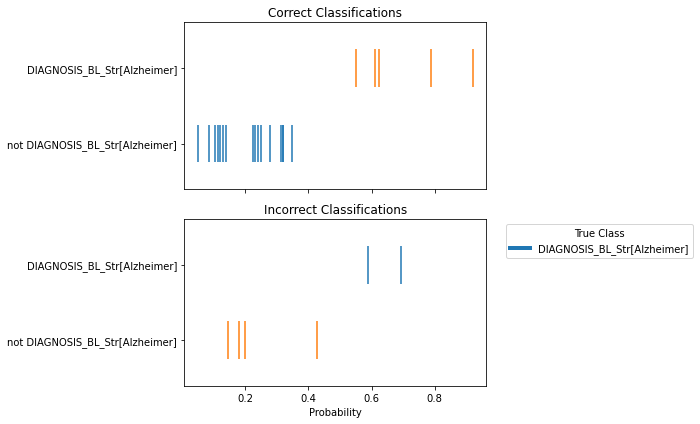

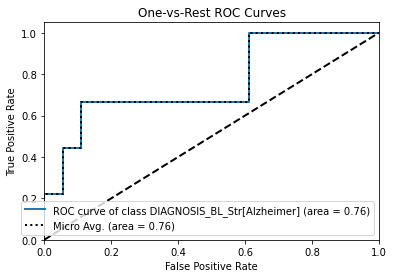

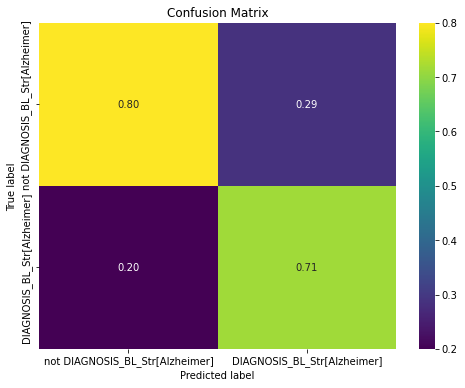

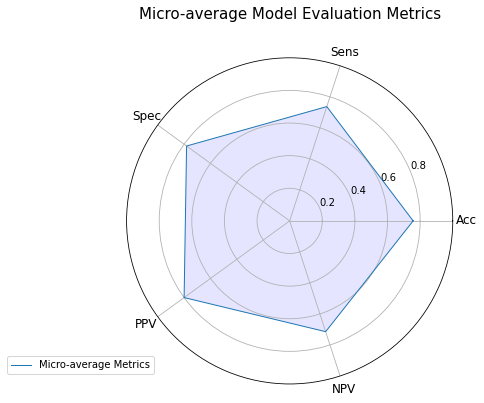

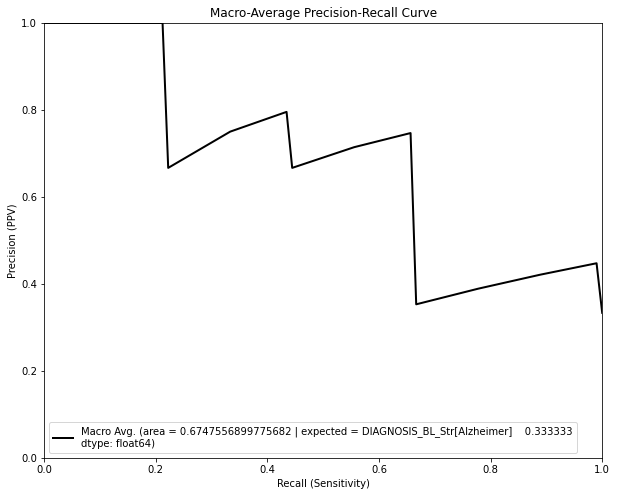

In [263]:
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
evaluator = ComprehensiveMulticlassROC(fitted_model=results, observation_df=outcome_matrix, normalization='pred', thresholds=None, out_dir=out_dir)
evaluator.run()

ADVANCED
- code specific manual thresholds to intervene upon classifications

Step 1: relate integer (index) to class

In [47]:
# evaluator.relate_index_to_class()

Step 2: in a dictionary of the indices (corresponding to class), key in the lambda function to edit the probability. 
- Code from left to right, giving priority to each method. 
- Example:
```
>thresholds = {
>            0: lambda probs: 0 if probs[0] > 0.5 else (1 if probs[0] > 0.25 else 2),  # Adjust class_0 predictions
>            1: lambda probs: None,  # No threshold adjustment for class_1
>            2: lambda probs: None   # No threshold adjustment for class_2
>        }
```

In [46]:
thresholds = {
    0: lambda prob: 0,  # Always keep class 0
    1: lambda prob: 1,  # Always keep class 1
    2: lambda prob: 2 if prob[2] > 0.5 else (1 if prob[1] > 0.3 else 0)  # Conditional adjustment for class 2
}


Step 3: Check the effect

In [ ]:
# from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
# evaluator = ComprehensiveMulticlassROC(fitted_model=results, observation_df=outcome_matrix, normalization='pred', thresholds=thresholds, out_dir=out_dir)
# evaluator.run()

Step 4: YOU MUST LOOCV AND VALIDATE IN OUT-OF-SAMPLE DATA.
- add thresholds as an argument to any further calls to ComprehensiveMulticlassROC

Bootstrap the Micro Average AUC

In [ ]:
import matplotlib
from calvin_utils.statistical_utils.classification_statistics import bootstrap_auc
matplotlib.use('Agg')  # Use a non-interactive backend

mean_auc, lower_ci, upper_ci = bootstrap_auc(outcome_matrix, design_matrix, n_iterations=1000)
print(f'Mean AUC: {mean_auc}, 95% CI: ({lower_ci}, {upper_ci})')

Permutation Test Two AUCs

In [ ]:
data_df.columns

In [354]:
f1 = "Diagnosis ~ CerebellumCSF + ParietalCSF + MTLCSF + OccipitalCSF + FrontalCSF + temp_ins_csf + SubcortexCSF"
f2 = "Diagnosis ~ CerebellumGM + ParietalGM + MTLGM + OccipitalGM + FrontalGM + temp_ins_gm + SubcortexGM"

In [ ]:
import matplotlib
matplotlib.use('Agg')  # Use a non-interactive backend
from calvin_utils.statistical_utils.classification_statistics import permute_auc_difference
obs_diff, lower_ci, upper_ci, p_value = permute_auc_difference(data_df, formula1=f1, 
                                                                  formula2=f2,
                                                                  cal_palm=cal_palm, n_iterations=1000)
print(f'Observde AUC Difference: {obs_diff}, 95% CI: ({lower_ci}, {upper_ci}), p-value: {p_value}')

# 06 - Visualize the Regression as a Forest Plot
- This will probably look poor if you ran a regression without standardizing your data. 

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import MultinomialForestPlot

multinomial_forest = MultinomialForestPlot(model=results, sig_digits=2, out_dir=None, table=False)
multinomial_forest.run()

# 07 - Generate Partial Dependence Plots

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import PartialDependencePlot
pdp = PartialDependencePlot(formula=formula, data_df=data_df, model=results, design_matrix=design_matrix, outcomes_df=outcome_matrix, data_range=None, out_dir=None, marginal_method='mean', debug=False)
pdp.run()

# 08 - Visualize the Partial Regression Plots

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import PartialRegressionPlot
partial_plot = PartialRegressionPlot(model=results, design_matrix=design_matrix, out_dir=out_dir, palette=None)
partial_plot = partial_plot.run()

# 09 - LOOCV

In [ ]:
import pandas as pd
from calvin_utils.statistical_utils.logistic_regression import LogisticRegression
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
y_true, y_pred, test_prob = LogisticRegression.run_loocv(outcome_matrix, design_matrix)
loocv_evaluator = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=pd.DataFrame(test_prob, columns=outcome_matrix.columns), observation_df=outcome_matrix, normalization='pred', thresholds=None, out_dir=out_dir)
loocv_evaluator.run()

# 10 - Predict Unseen Data

In [32]:
new_csv_path='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/dataset_4/scm_validation/SCM_spatial_corr_matrix.csv'

Optional - Get New Data

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# # Instantiate the PalmPrepararation class
new_palm = CalvinStatsmodelsPalm(input_csv_path=new_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
other_df = new_palm.read_and_display_data()
other_df

In [68]:
# formula

In [69]:
# column_renaming_map = {
#                        'Mesial_Temporal': 'mesial_temporal_eh', 
#                        'parietal': 'parietal_eh', 
#                        'frontal': 'frontal_eh',
#                        'temporal': 'temporal_eh', 
#                        'ventricle':'ventricle_eh',
#                        'occipital': 'occipital_eh'}

In [70]:
# other_df.rename(columns=column_renaming_map, inplace=True)

Prepare Data

In [270]:
# Define the design matrix
# subset_df = other_df.groupby('DIAGNOSIS_BL').apply(lambda x: x.sample(min(len(x), 200))).reset_index(drop=True)
import pandas as pd
other_outcome_matrix, other_design_matrix = cal_palm.define_design_matrix(formula, other_df)

# Ensure both matrices have the same columns
if len(other_outcome_matrix.columns) != len(outcome_matrix.columns):
    # Create a zero-filled DataFrame with the same columns as outcome_matrix
    zero_df = pd.DataFrame(0, index=other_outcome_matrix.index, columns=outcome_matrix.columns)
    
    # Fill zero_df with values from other_outcome_matrix where columns exist
    common_columns = other_outcome_matrix.columns.intersection(outcome_matrix.columns)
    zero_df.loc[:, common_columns] = other_outcome_matrix.loc[:, common_columns]
    
    other_outcome_matrix = zero_df

other_outcome_matrix


,DIAGNOSIS_BL_Str[Alzheimer]
0,0.0
1,0.0
5,0.0
6,0.0
7,0.0
...,...
145,1.0
146,1.0
147,1.0
148,1.0


Predict

Evaluate

In [271]:
formula

'DIAGNOSIS_BL_Str ~ CTh_Frontal + CTh_Parietal + CTh_Occipital + CTh_Temporal + CTh_MTL'

In [272]:
# thresholds = {
#     0: lambda prob: 0 if prob < 0.33 else 1,
#     1: lambda prob: 1 if prob > 0.33 else 0
# }

Taking maximum probability as prediction.
There are 48.0 observations for DIAGNOSIS_BL_Str[Alzheimer]
Optimal Thresholds: 
 {0: 0.4510560987436797}


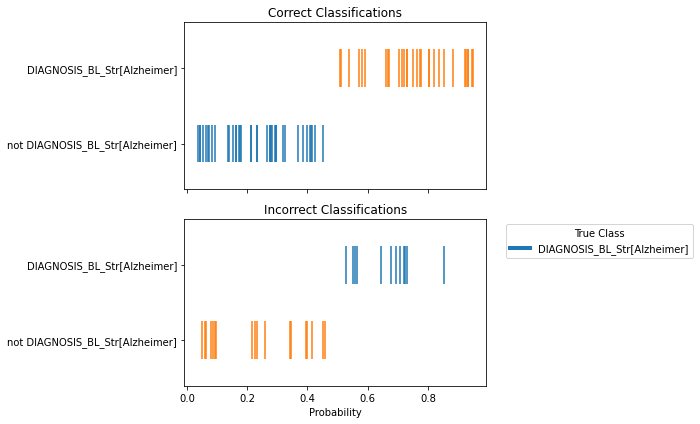

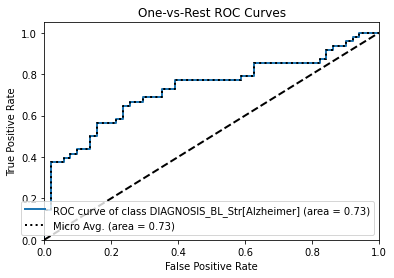

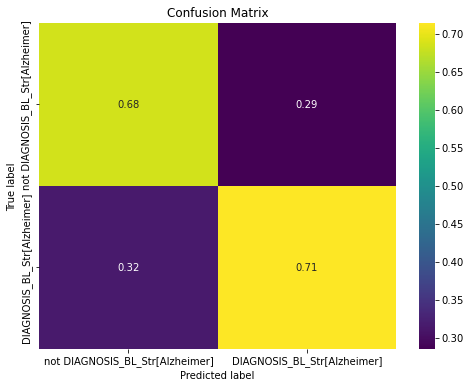

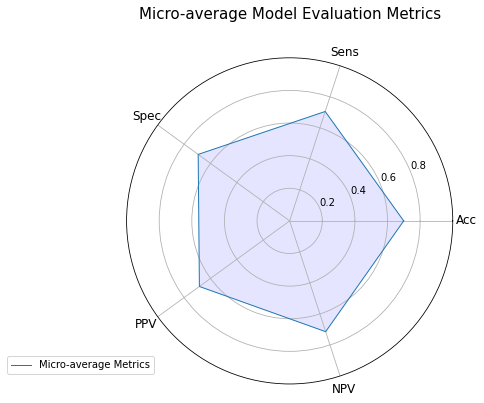

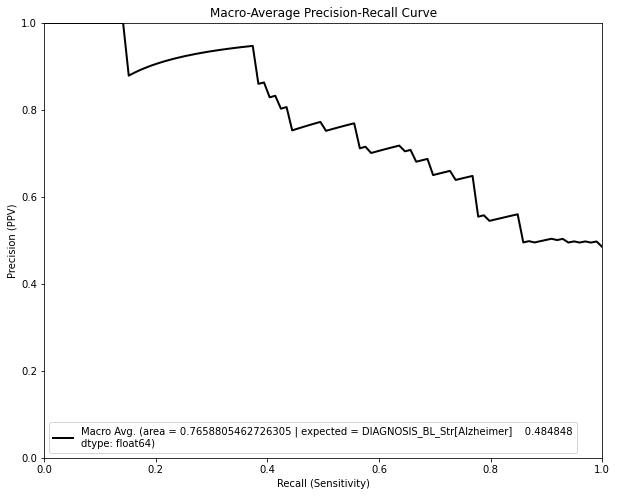

In [273]:
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
loocv_evaluator = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=results.predict(other_design_matrix), observation_df=other_outcome_matrix, normalization='pred', thresholds=None, out_dir=out_dir)
loocv_evaluator.run()

In [274]:
loocv_evaluator.get_micro_auc()

Taking maximum probability as prediction.
There are 48.0 observations for DIAGNOSIS_BL_Str[Alzheimer]


0.7312091503267973

In [275]:

###----- Functionally Programmed Functions for Evaluation Using Above Classes -----##
'''
Hanging imports to facilitate easy transplant of code.
'''
import numpy as np
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
from calvin_utils.statistical_utils.logistic_regression import LogisticRegression
import os
from contextlib import redirect_stdout, redirect_stderr
from tqdm import tqdm

def resample_df(data_df):
    n_samples = data_df.shape[0]
    # Shuffle the indices
    shuffled_indices = np.random.permutation(n_samples)
    # Reorder the DataFrame based on the shuffled indices but keep the original index
    shuffled_df = data_df.iloc[shuffled_indices].reset_index(drop=True).set_index(data_df.index)
    return shuffled_df

def permute_auc_difference(data_df, formula1, formula2, cal_palm, n_iterations=1000):
    auc_diffs = []
    for i in tqdm(range(n_iterations)):
        try:
            with open(os.devnull, 'w') as fnull, redirect_stdout(fnull), redirect_stderr(fnull):
                # Define design matrices and outcome matrices for both formulas
                outcome_matrix, design_matrix1 = cal_palm.define_design_matrix(formula1, data_df)
                _, design_matrix2 = cal_palm.define_design_matrix(formula2, data_df)
                
                # Permute the outcomes
                if i == 0:
                    resampled_df = outcome_matrix
                else:
                    resampled_df = resample_df(outcome_matrix)

                # Fit the logistic regression model for the first formula
                logreg1 = LogisticRegression(resampled_df, design_matrix1)
                results1 = logreg1.run()

                # Fit the logistic regression model for the second formula
                logreg2 = LogisticRegression(resampled_df, design_matrix2)
                results2 = logreg2.run()

                # Evaluate the models
                evaluator1 = ComprehensiveMulticlassROC(fitted_model=results1, observation_df=resampled_df, normalization='true', thresholds=None, out_dir=None)
                micro_auc1 = evaluator1.get_micro_auc()

                evaluator2 = ComprehensiveMulticlassROC(fitted_model=results2, observation_df=resampled_df, normalization='true', thresholds=None, out_dir=None)
                micro_auc2 = evaluator2.get_micro_auc()

                # Store the difference in micro-average AUCs
                if i == 0:
                    obs_diff = micro_auc1 - micro_auc2
                    print(f"F1: {micro_auc1} | F2: {micro_auc2}")
                else:
                    auc_diffs.append(micro_auc1 - micro_auc2)
            
        except Exception as e:
            print(e)
            continue
    # Calculate p-value based on the distribution of differences
    auc_diffs = np.array(auc_diffs)
    p_value = np.mean(auc_diffs >= obs_diff)

    # Calculate confidence intervals for the difference
    lower_ci = np.percentile(auc_diffs, 2.5)
    upper_ci = np.percentile(auc_diffs, 97.5)
    
    return obs_diff, lower_ci, upper_ci, p_value

def bootstrap_auc(outcome_matrix, design_matrix, n_iterations=1000, model=None):
    auc_scores = []
    n_samples = outcome_matrix.shape[0]
    
    for i in tqdm(range(n_iterations)):
        # Suppress both stdout and stderr
        try:
            with open(os.devnull, 'w') as fnull, redirect_stdout(fnull), redirect_stderr(fnull):
                # Generate a bootstrap sample
                resample_idx = np.random.choice(n_samples, size=n_samples, replace=True)
                outcome_matrix_resampled = outcome_matrix.iloc[resample_idx]
                design_matrix_resampled = design_matrix.iloc[resample_idx]

                # Fit the logistic regression model
                if model is None:
                    logreg = LogisticRegression(outcome_matrix_resampled, design_matrix_resampled)
                    results = logreg.run()
                    test = ComprehensiveMulticlassROC(fitted_model=results, observation_df=outcome_matrix_resampled, normalization='true', thresholds=None, out_dir=None)
                else:
                    results = model.predict(design_matrix_resampled)
                    test = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=results, observation_df=outcome_matrix_resampled, normalization='true', thresholds=None, out_dir=None)
                # Evaluate the model
                micro_auc = test.get_micro_auc()
                auc_scores.append(micro_auc)
        except:
            continue
    # Calculate confidence intervals
    lower_ci = np.percentile(auc_scores, 2.5)
    upper_ci = np.percentile(auc_scores, 97.5)    
    return np.mean(auc_scores), lower_ci, upper_ci, auc_scores


Bootstrap the Micro Average AUC

In [276]:
import matplotlib
# from calvin_utils.statistical_utils.classification_statistics import bootstrap_auc
matplotlib.use('Agg')  # Use a non-interactive backend
mean_auc, lower_ci, upper_ci, auc_dist = bootstrap_auc(other_outcome_matrix, other_design_matrix, n_iterations=1000, model=results)
print(f'Mean AUC: {mean_auc}, 95% CI: ({lower_ci}, {upper_ci})')

100%|██████████| 1000/1000 [00:01<00:00, 981.92it/s]

Mean AUC: 0.7318701924183804, 95% CI: (0.6253035839540398, 0.8281731771268246)


In [165]:
import pandas as pd
auc_df = pd.DataFrame({'val':auc_dist})
auc_df.to_csv('/path/to/df.csv')

In [175]:
auc_df = pd.read_csv('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/atrophy_seeds_2023/Figures/diagnostic_ability/50fit_150pred/auc_dist.csv')

In [ ]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

def compare_bootstrapped_means(distribution1, distribution2):
    """
    Compares two bootstrapped distributions using a two-sample t-test and Mann-Whitney U test.
    
    Parameters:
    - distribution1 (list or array): Bootstrapped distribution of group 1.
    - distribution2 (list or array): Bootstrapped distribution of group 2.
    
    Returns:
    - t_stat (float): t-statistic from the two-sample t-test.
    - t_p_value (float): p-value from the two-sample t-test.
    - u_stat (float): U-statistic from the Mann-Whitney U test.
    - u_p_value (float): p-value from the Mann-Whitney U test.
    """
    # Perform a two-sample t-test to compare means
    t_stat, t_p_value = ttest_ind(distribution1, distribution2)
    
    # Perform a Mann-Whitney U test to compare distributions
    u_stat, u_p_value = mannwhitneyu(distribution1, distribution2)

    return t_stat, t_p_value, u_stat, u_p_value

# Compare the distributions
t_stat, t_p_value, u_stat, u_p_value = compare_bootstrapped_means(auc_df['CSF AUCs'], auc_df['CTh AUCs'])

print(f"Two-sample t-test: t-stat = {t_stat:.4f}, p-value = {t_p_value:.4f}")
print(f"Mann-Whitney U test: U-stat = {u_stat:.4f}, p-value = {u_p_value:.4f}")


Plot Bootstraps

In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_custom_bootstrap_auc(df):
    """
    Plots the mean and error bars of AUCs for each column in the DataFrame using Seaborn and Matplotlib,
    styled similarly to the reference plot.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing bootstrapped AUC distributions. 
                         Each column represents a different group.
    """
    # Initialize lists to store plotting data
    means = []
    lower_errors = []
    upper_errors = []
    y_labels = []

    # Calculate mean and confidence intervals for each column in the DataFrame, ignoring NaNs
    for column in df.columns:
        bootstrapped_values = df[column].dropna()  # Remove NaN values
        if len(bootstrapped_values) > 0:
            mean_value = np.mean(bootstrapped_values)
            lower_ci = np.percentile(bootstrapped_values, 2.5)
            upper_ci = np.percentile(bootstrapped_values, 97.5)
            
            means.append(mean_value)
            lower_errors.append(mean_value - lower_ci)
            upper_errors.append(upper_ci - mean_value)
            y_labels.append(column)

    # Create a horizontal scatter plot with error bars
    plt.figure(figsize=(6, len(means) * 1.2))  # Adjust height based on number of groups
    sns.set(style="whitegrid")
    
    # Assign colors from a color palette
    palette = sns.color_palette("tab10", len(means))

    # Plot the means as points with error bars
    for i, (mean, lower_err, upper_err, label) in enumerate(zip(means, lower_errors, upper_errors, y_labels)):
        plt.errorbar(x=mean, y=i, xerr=[[lower_err], [upper_err]], fmt='o', color=palette[i], capsize=5, markersize=10)
    
    # Customize y-ticks to match labels
    plt.yticks(range(len(y_labels)), y_labels)
    
    # Labels and title
    plt.xlabel('AUC')
    plt.ylabel('CAD Product')
    plt.title('Mean AUC with 95% CI for CAD Products')

    # Customize the grid and layout
    plt.grid(False)
    plt.xlim(0.4, 1.0)  # Set x-axis limits for AUC

    # Display the plot
    plt.tight_layout()
    plt.show()
    plt.savefig(out_dir + '/95ci.svg')

plot_custom_bootstrap_auc(auc_df)

NameError: name 'auc_df' is not defined

Permutation Test Two AUCs

In [ ]:
other_df.columns

In [54]:
f1 = "Diagnosis ~ CSF_Frontal + CSF_Temporal + CSF_Parietal + CSF_Occipital + CSF_MTL + CSF_Cerebellum + CSF_Subcortex"
f2 = "Diagnosis ~ GM_Frontal + GM_Temporal + GM_Parietal + GM_Occipital + GM_MTL + GM_Cerebellum + GM_Subcortex"

In [ ]:
# from calvin_utils.statistical_utils.classification_statistics import permute_auc_difference
obs_diff, lower_ci, upper_ci, p_value = permute_auc_difference(other_df, formula1=f1, 
                                                                  formula2=f2,
                                                                  cal_palm=cal_palm, n_iterations=1000)
print(f'Observed AUC Difference: {obs_diff}, 95% CI: ({lower_ci}, {upper_ci}), p-value: {p_value}')